In [1]:
#!pip install scikit-learn
#!pip install scikit-spatial
#!pip install pyransac3d

%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import ArducamDepthCamera as ac
from sklearn.cluster import HDBSCAN
import pyransac3d as pyrsc
from collections import Counter
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from functions import *


def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):
    image = cv2.cvtColor(image, conversion)

    plt.imshow(image)

    plt.xticks([])
    plt.yticks([])

    if title is not None:
        plt.title(title)

    plt.show()


def read_frame(cam, timeout=1000):
    frame = cam.requestFrame(timeout)
    confidence_buf = frame.confidence_data
    depth_buf = frame.depth_data
    
    confidence_buf[confidence_buf < 0] = 0.0
    confidence_buf[confidence_buf > 255] = 255.0

    cam.releaseFrame(frame)

    return depth_buf, confidence_buf    

# MAX_DISTANCE value modifiable is 2000 or 4000
cam, r, K = init_camera(2000)

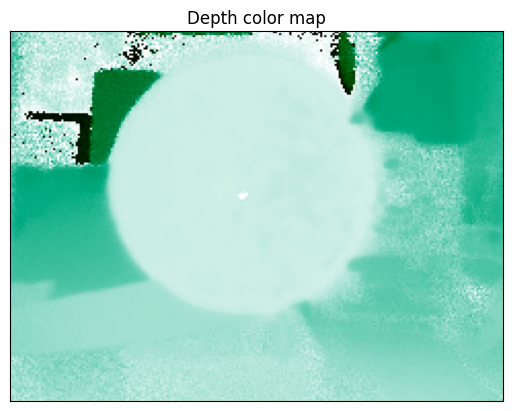

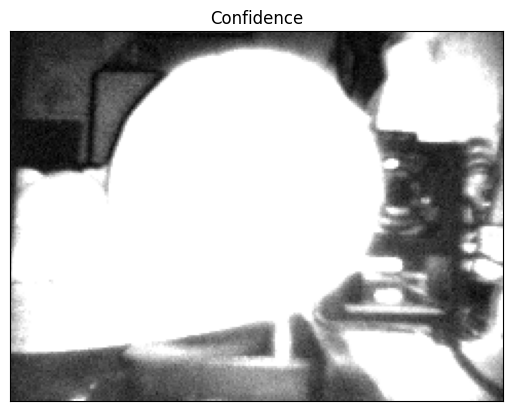

In [5]:
depth_buf, confidence_buf = read_frame(cam)
depth_buf = normalize_depth(depth_buf, r)

#colormap = filtered_by_confidence(depth_buf, confidence_buf, 200)

colormap = np.nan_to_num(depth_buf.copy())
colormap = colormap.astype(np.uint8)
colormap = cv2.applyColorMap(255 - colormap, cv2.COLORMAP_DEEPGREEN)

show_rgb_image(colormap, "Depth color map")
show_rgb_image(confidence_buf.astype(np.uint8), "Confidence")

In [6]:
depth_buf = filter_by_confidence(depth_buf, confidence_buf, 250)
aim, gx, gy = aim_metrics(depth_buf)

print(aim)
print(gx)
print(gy)    

(17.94158, 1.1792909)
(0.12723881, 0.5391628)
(0.1465316, 0.7720962)


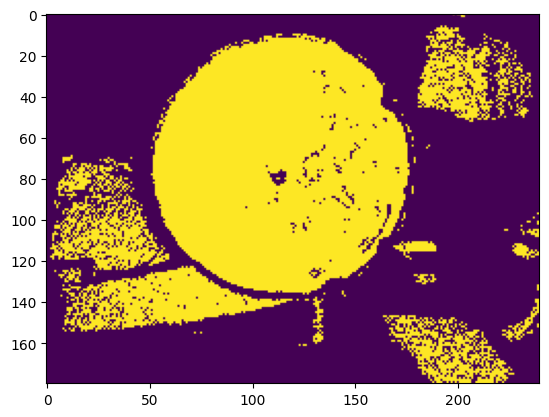

In [7]:
plt.imshow(filter_by_gradients(depth_buf, gx,  gy, 3))

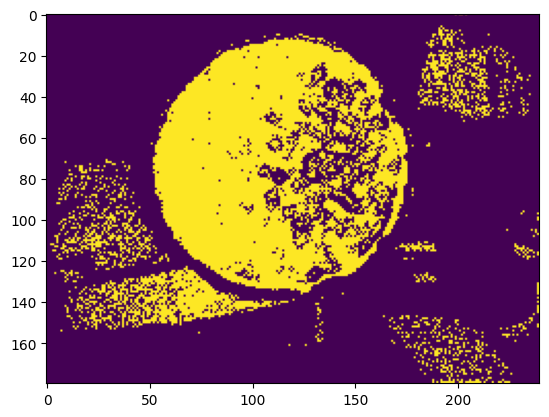

In [8]:
combined_depth = np.zeros(depth_buf.shape).astype(np.uint8)

for i in range(3):
    depth_buf, confidence_buf = read_frame(cam)
    depth_buf = filter_by_confidence(depth_buf, confidence_buf, confindence_threshold=250)
    tmean, tgxmean, tgymean = aim_metrics(depth_buf)
    filtered_depth = filter_by_gradients(depth_buf, tgxmean, tgymean, 1)
    combined_depth = combined_depth | filtered_depth

plt.imshow(combined_depth)

In [9]:
point_2d_coords = points_to_coords(combined_depth)
points_3d_coords = combine_2d_and_depth(point_2d_coords, depth_buf)
points_3d_coords_real = np.apply_along_axis(lambda row: uv_to_world(K, row[:2], row[2]), 1, points_3d_coords)

hdb = HDBSCAN()
hdb.fit(points_3d_coords_real)

densiest_cluster = sorted(Counter(hdb.labels_).items(), key=lambda x: x[1], reverse=True)[0][0]

points_3d_coords_real_clustered = points_3d_coords_real[(hdb.labels_ == densiest_cluster) & (hdb.probabilities_ > 0.8)]

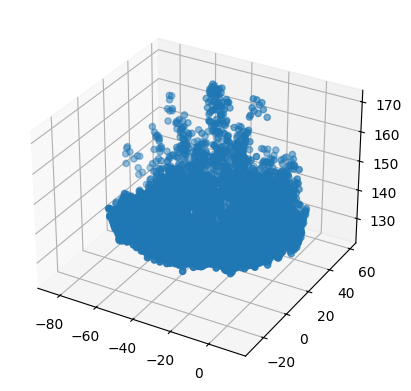

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points_3d_coords_real_clustered[:, 0], points_3d_coords_real_clustered[:, 1], points_3d_coords_real_clustered[:, 2])
plt.show()

[0.02212386299301915, -0.12279946048361955, -0.9921848755102035, 140.09023486694093]


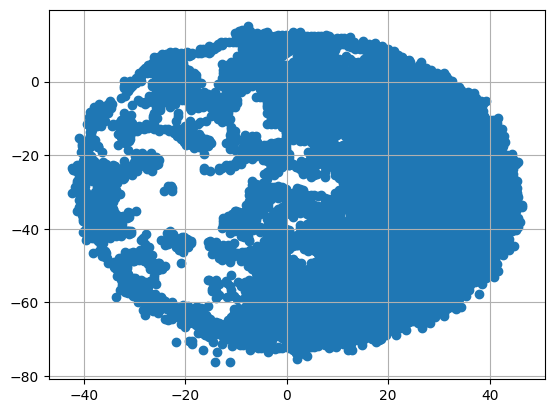

In [12]:
projected_x, projected_y = points_3d_fit_plane(points_3d_coords_real_clustered, 5)

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(projected_y, projected_x)

plt.grid()
plt.show()

297.4809951647426


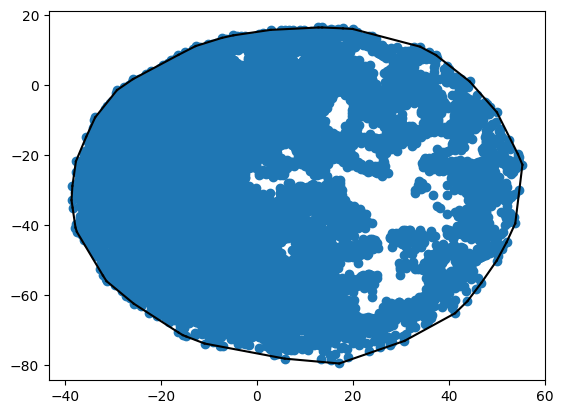

In [29]:
projected_points = np.column_stack((projected_y, projected_x))

hull = ConvexHull(projected_points, qhull_options="FS")
print(hull.area)

plt.plot(projected_points[:,0], projected_points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(projected_points[simplex, 0], projected_points[simplex, 1], 'k-')
plt.show()

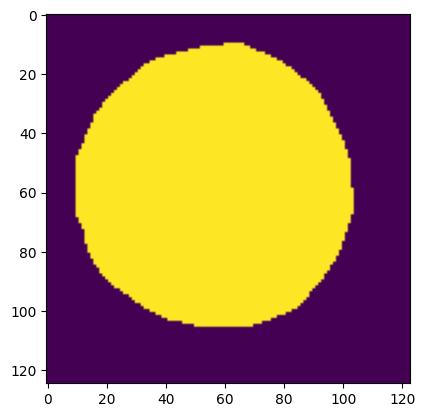

In [30]:
hull_points_x, hull_points_y = projected_points[hull.vertices, 0], projected_points[hull.vertices, 1]
min_hull_points_x = min(hull_points_x)
min_hull_points_y = min(hull_points_y)

hull_points_x = (hull_points_x - min_hull_points_x + 10).astype(np.int32)
hull_points_y = (hull_points_y - min_hull_points_y + 10).astype(np.int32)

img = np.zeros((max(hull_points_y) + 20, max(hull_points_x) + 20))
img = cv2.fillPoly(img, [np.column_stack((hull_points_x, hull_points_y)).reshape((-1,1,2))], 1)
plt.imshow(img)

In [32]:
area, centroid_x, centroid_y, a, b, c, tau1, tau2, roundness = compute_momentums(img)
print(area, centroid_x, centroid_y, a, b, c, tau1, tau2, roundness)

side_small = np.sqrt(area * roundness / np.pi) * 2
side_big = side_small / roundness
print(side_small, side_big)

7080.0 56.5066384180791 58.427542372881355 3909773.68799435 47728.8110169491 4075140.8292372883 1.4303027972424216 3.001099124037318 0.9577990605580609
92.91993375952224 97.01401639022544


(32, 151) (82, -34)
(-34, 33) (150, 83)


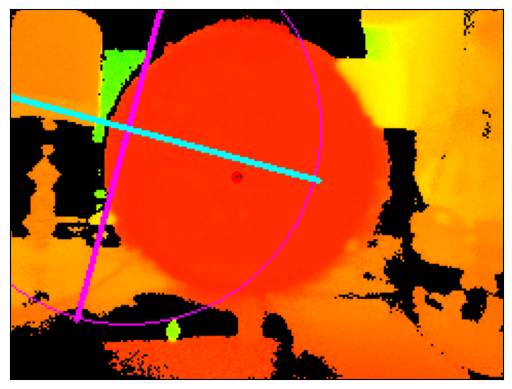

In [71]:
# ellipse_image = cv2.cvtColor(result_image, cv2.COLOR_GRAY2RGB)
ellipse_image = result_image.copy()
cv2.ellipse(ellipse_image, (int(centroid_x), int(centroid_y)), (int(side_big-1), int(side_small-1)), 360 * (tau1 / (2 * np.pi)), 0, 360, color=[255, 0, 255])

start_big = int(centroid_x - np.cos(tau1) * side_big), int(centroid_y - np.sin(tau1) * side_big)
end_big = int(centroid_x + np.cos(tau1) * side_big), int(centroid_y + np.sin(tau1) * side_big)
print(start_big, end_big)
cv2.line(ellipse_image, start_big, end_big, [255, 0, 255], 2)

start_small = int(centroid_x - np.cos(tau2) * side_small), int(centroid_y - np.sin(tau2) * side_small)
end_small = int(centroid_x + np.cos(tau2) * side_small), int(centroid_y + np.sin(tau2) * side_small)
print(start_small, end_small)
cv2.line(ellipse_image, start_small, end_small, [255, 255, 0], 2)

show_rgb_image(ellipse_image)